<h2>Interactive Experiment</h2>
<font size="3" face="Verdana">
<p style="text-align:justify">Here, you find an impelementation of Fitts experiment in 2D. </p>
<p style="text-align:justify">To start it, click into the first code-block and press the "Run" button at the top of this page.</p> 
<p>A grey square will appear with dots arranged in a circle, one red and all others white. Always click on the red dot as fast as possible. When everything turns green, the experiment is complete. Then you can click in the next code block and again press "Run" to show the results.</p>
</font>

In [1]:
from ipycanvas import Canvas
import numpy as np
import math
from ipywidgets import Label, HTML, HBox, Image, VBox, Box, HBox
from ipyevents import Event
from IPython.display import display
from datetime import datetime
import matplotlib.pyplot as plt


global_width = 900
global_height = 900

canvas = Canvas(width=global_width, height=global_height)

canvas.fill_style = 'gray'
canvas.fill_rect(0, 0, global_width, global_height)



#get list of positions for circles
def listOfPositions(number, radius, midpointX, midpointY):
    diffAngle = 360/number
    positions = np.zeros((number,2))
    
    for i in range(number):
        positions[i][0] = midpointX + math.sin((diffAngle*i)/360 * 2 * math.pi) * radius;
        positions[i][1] = midpointY + math.cos((diffAngle*i)/360 * 2 * math.pi) * radius;
    return positions


def listOfOrders(num):
    orders = np.zeros(num)
    n = int(num/2)
    for i in range(n):
        orders[i*2] = i
        orders[i*2+1] = num/2 + i 
    return orders


#def positionPoints(numberOfPoints, IndxRed, pos, width):
def positionPoints(numberOfPoints, order, width, distance, IndxRed):
    global global_width
    global global_height
    global pos 
    
    canvas.fill_style = 'gray'
    canvas.fill_rect(0, 0, global_width, global_height)
    
    pos = listOfPositions(numberOfPoints, distance/2, global_width/2, global_height/2)
    for i in range(numberOfPoints):
        if i == order[IndxRed]:
            canvas.fill_style = 'red'
            canvas.fill_circle(pos[i][0],pos[i][1], width/2)
        else:
            canvas.fill_style = 'snow'
            canvas.fill_circle(pos[i][0],pos[i][1], width/2)

            
def isClickInPoint(x, y, pos, orderIndx, width):
    distanceToPoint = math.sqrt((pos[int(orderIndx)][0] - x)**2 + (pos[int(orderIndx)][1] - y)**2)
    if distanceToPoint <= width/2:
        return True
    else:
        return False
    

    
def handle_mouse_down(x, y):
    global distance
    global width
    global IndxRed
    global indxRepeat
    global distanceArray
    global indxDist
    global widthArray
    global indxWidth
    global global_width
    global global_height
    global end
    global d_length
    global w_length
    global numRepeat
    global pos
    global order
    
    if end:
        return False
    
    #check if point was hit
    if isClickInPoint(x, y, pos, order[IndxRed], width):
        #timestamp
        timestamps[indxDist, indxWidth, indxRepeat] = datetime.utcnow().timestamp()
        
        indxRepeat += 1
        #change conditions
        if indxRepeat == numRepeat:
            indxRepeat = 0
            IndxRed = -1
            indxWidth += 1
            if indxWidth == w_length:
                indxWidth = 0
                indxDist += 1
                if indxDist == d_length:
                    canvas.fill_style = 'green'
                    canvas.fill_rect(0,0, global_width, global_height)
                    end = True
        #if point was hit, go to next point
        IndxRed += 1
        width = widthArray[indxWidth]
        distance = distanceArray[indxDist]
        positionPoints(numRepeat, order, width, distance, IndxRed)    
    
    pass

canvas.on_mouse_down(handle_mouse_down)


#initialize
distanceArray = [200, 400, 800]
widthArray = [15, 30, 60]
d_length = len(distanceArray)
w_length = len(widthArray)
indxDist = 0
indxWidth = 0
indxRepeat = 0
numRepeat = 10
timestamps = np.zeros((d_length, w_length, numRepeat))
end = False

width = widthArray[indxWidth]
distance = distanceArray[indxDist]
IndxRed = 0
order = listOfOrders(numRepeat)
pos = listOfPositions(numRepeat, distance/2, global_width/2, global_height/2)
positionPoints(numRepeat, order, width, distance, IndxRed)




canvas

Canvas(height=900, width=900)

In [2]:
#compute differences between two clicks
deltaTimes = np.zeros((d_length,w_length,numRepeat-1))
for i in range(d_length):
    for j in range(w_length):
        for t in range(numRepeat-1):
            deltaTimes[i,j,t] = timestamps[i,j,t+1] - timestamps[i,j,t]
            
    
#compute average time between two clicks for each condition
averageDeltaTimes = np.zeros((d_length,w_length))
for i in range(d_length):
    for j in range(w_length):
        sum = 0.0
        for t in range(numRepeat-1):
            sum += deltaTimes[i,j,t]
        averageDeltaTimes[i,j] = round(sum/(numRepeat-1),4)
        

#compute index of difficulty for each condition
indxOfDifficulty = np.zeros((d_length*w_length))
for i in range(d_length):
    for j in range(w_length):
        indxOfDifficulty[i*w_length+j] = round(np.log2(2*distanceArray[i] / widthArray[j]),4)
        
        
#compute index of performance for each condition
indxOfPerformance = np.zeros((d_length*w_length))
for i in range(d_length):
    for j in range(w_length):
        indxOfPerformance[i*w_length+j] = round(indxOfDifficulty[i*w_length+j]/averageDeltaTimes[i][j],4)

        


print("RESULT")
print("Distance in pixel | Width in pixel | Time in seconds | Index of Difficulty | Index of Performance ")
for i in range(d_length):
    for j in range(w_length): 
        print(distanceArray[i], "               ", widthArray[j], "             ", averageDeltaTimes[i,j], "          ", indxOfDifficulty[i*w_length+j], "              ", indxOfPerformance[i*w_length+j])

   


times = averageDeltaTimes.flatten()

#compute linear regression
IDmatrix = np.ones((len(indxOfDifficulty), 2))
IDmatrix[:,1] = indxOfDifficulty
ABmatrix = np.linalg.pinv(IDmatrix).dot(times)

xLine = np.arange(2, 8, 1)

#Plot Experiment result with linear regression
plt.plot(indxOfDifficulty, times, 'bo', xLine, ABmatrix[0]+ABmatrix[1]*xLine, 'r')
plt.xlabel('Index of Difficulty')
plt.ylabel('Time')
plt.show()

print("Device specific constants:")
print("a: ", ABmatrix[0])
print("b: ", ABmatrix[1])

RESULT
Distance in pixel | Width in pixel | Time in seconds | Index of Difficulty | Index of Performance 
200                 15               0.7449            4.737                6.3592
200                 30               0.6253            3.737                5.9763
200                 60               0.4813            2.737                5.6867
400                 15               0.9705            5.737                5.9114
400                 30               0.6848            4.737                6.9173
400                 60               0.576            3.737                6.4878
800                 15               1.2379            6.737                5.4423
800                 30               0.8799            5.737                6.5201
800                 60               0.6935            4.737                6.8306


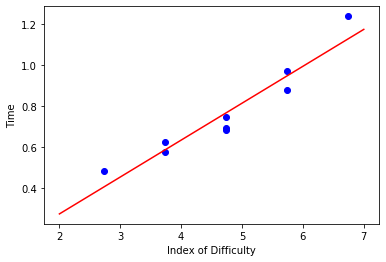

Device specific constants:
a:  -0.08755681388888914
b:  0.1801916666666667
